### Abstract 

In this task we try to gain insights about how motor insurance price can variate on different geographic locations and build a predictive model for mean price per postcode sector.

We used a Random Forest Model which performs with a Mean Absolute Error of 200 in the mean premium price. Based on the subsequent analysis, it seems that the most important factors affecting the price are the crime deprivation index and the population density.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from IPython.display import display, Markdown, Latex

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold

In [2]:
# Set label sizes for plots
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15


### Load and Check Data

In [3]:
authority_data = pd.read_csv('local_authority_data.csv')
display(authority_data.head())
display('Dataset Dimensions: ', authority_data.shape)
display(authority_data.info())

,postcode_sector,road_usage,total_offences,vehicle_offences
0,DL11,566.0,12666.0,703.0
1,DL12,566.0,12666.0,703.0
2,DL13,566.0,12666.0,703.0
3,DL14,566.0,12666.0,703.0
4,DL15,566.0,12666.0,703.0


'Dataset Dimensions: '

(8246, 4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8246 entries, 0 to 8245
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   postcode_sector   8246 non-null   object 
 1   road_usage        8246 non-null   object 
 2   total_offences    7290 non-null   float64
 3   vehicle_offences  7290 non-null   float64
dtypes: float64(2), object(2)
memory usage: 257.8+ KB


None

In [4]:
postcode_data = pd.read_csv('postcode_sector_data.csv')
display(postcode_data.head())
display('Dataset Dimensions: ', authority_data.shape)
display(authority_data.info())

,postcode_sector,relative_area,population_density,multiple_deprivation_index,income_deprivation_index,employment_deprivation_index,crime_deprivation_index,rural_urban,distance_to_station,never_worked,region
0,AB101,1354.03,53.819802,16.748,0.105,0.091,-0.028,Large urban area,0.829961,Average,Scotland
1,AB106,458.99,86.465844,16.748,0.105,0.091,-0.028,Large urban area,1.609040,Average,Scotland
2,AB107,1053.10,55.795067,16.748,0.105,0.091,-0.028,Large urban area,2.899283,Average,Scotland
3,AB115,2317.54,60.742963,16.748,0.105,0.091,-0.028,Large urban area,0.773404,Average,Scotland
4,AB116,918.22,95.784434,16.748,0.105,0.091,-0.028,Large urban area,0.533438,Average,Scotland


'Dataset Dimensions: '

(8246, 4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8246 entries, 0 to 8245
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   postcode_sector   8246 non-null   object 
 1   road_usage        8246 non-null   object 
 2   total_offences    7290 non-null   float64
 3   vehicle_offences  7290 non-null   float64
dtypes: float64(2), object(2)
memory usage: 257.8+ KB


None

In [5]:
quote_prices = pd.read_csv('quote_prices.csv')
display(quote_prices.head())
display('Dataset Dimensions: ', quote_prices.shape)
display(quote_prices.info())

,postcode,premium_price
0,B975BQ,324.58
1,UB33PN,3245.06
2,RH149XP,197.84
3,W130AG,1253.53
4,M145DT,514.05


'Dataset Dimensions: '

(1000000, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   postcode       1000000 non-null  object 
 1   premium_price  1000000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 15.3+ MB


None

In [6]:
authority_data['postcode_sector'].nunique()

8246

In [7]:
postcode_data['postcode_sector'].nunique()

11049

#### Combine Datasets

In [8]:
dataset = postcode_data.merge(authority_data, on='postcode_sector', how='left')

#### Get Postcode sector from postcode

In [9]:
dataset['postcode_sector'].nunique()

11049

We need to get the postcode sector from the postcodes. 

In [10]:
("Number of characters for individual postcode sectors", dataset['postcode_sector'].apply(lambda x:len(x)).value_counts())



('Number of characters for individual postcode sectors',
 5    5430
 4    5242
 3     377
 Name: postcode_sector, dtype: int64)

In [11]:
("Number of characters for individual postcodes", quote_prices['postcode'].apply(lambda x:len(x)).value_counts())



('Number of characters for individual postcodes',
 6    565169
 7    398234
 5     36597
 Name: postcode, dtype: int64)

In [12]:
quote_prices.sort_values('postcode').head(n=20)['postcode']

39543     AB101AN
39414     AB101AN
41594     AB101HW
41606     AB101HW
41588     AB101HW
36038     AB101HW
35982     AB101HW
35994     AB101HW
36021     AB101HW
36009     AB101HW
36001     AB101HW
36028     AB101HW
486905    AB101JX
486918    AB101JX
448098    AB101JX
188234    AB101QN
216355    AB101RQ
216407    AB101RQ
326141    AB101SJ
397416    AB101SN
Name: postcode, dtype: object

In [13]:
dataset.sort_values('postcode_sector').head(n=20)['postcode_sector']

0     AB101
1     AB106
2     AB107
3     AB115
4     AB116
5     AB117
6     AB118
7     AB119
8     AB123
9     AB124
10    AB125
11    AB129
12    AB130
13    AB140
14    AB154
15    AB155
16    AB156
17    AB157
18    AB158
19    AB159
Name: postcode_sector, dtype: object

If remove the last two characters from the postcodes we shall be able to get the majority of the postcode sectors.

In [14]:
quote_prices['postcode_sector'] = quote_prices['postcode'].apply(lambda x:x[:-2])
quote_prices['postcode_sector'].nunique()

9186

### Exploratory Data Analysis

#### Target Variable: Premium Price

*The aim is to use publicly available data on postcode sectors to gain insight into how the price of motor insurance relates to geographic location*

So we need to get the motor price per postcode sector. 

Let's have a look at some stats to understand how much it can vary per postcode sector:

In [15]:
quote_prices_stats = quote_prices.groupby('postcode_sector')['premium_price'].agg(['min','median', 'mean', 'std', 'max', 'count']).reset_index()
quote_prices_stats.columns = ['postcode_sector', 
                              'price_min', 
                              'price_median',
                              'price_mean', 
                              'price_std',
                              'price_max',
                              'num_quotes']

display(quote_prices_stats.head(n=30))

,postcode_sector,price_min,price_median,price_mean,price_std,price_max,num_quotes
0,AB101,162.15,1028.890,1089.114048,772.176627,3991.06,42
1,AB106,132.55,417.655,681.312556,1141.572745,6766.20,90
2,AB107,135.32,576.005,629.203778,399.690221,2280.79,90
3,AB115,344.57,2217.630,1935.176471,731.891186,2767.53,17
4,AB116,184.99,647.390,718.888242,389.086128,1876.61,91
5,AB117,136.84,294.905,455.881176,356.191983,1479.26,34
6,AB118,190.99,354.910,747.837692,664.283155,4120.52,91
7,AB119,154.74,911.110,1105.452364,779.815508,3803.84,55
8,AB123,106.29,610.555,677.744750,595.265007,4982.01,120
9,AB124,126.02,431.850,854.428824,1018.342791,6574.98,119


In [16]:
display(quote_prices_stats.tail(n=30))

,postcode_sector,price_min,price_median,price_mean,price_std,price_max,num_quotes
9156,YO421,185.36,504.595,583.807500,322.445086,1486.04,48
9157,YO422,149.41,744.230,942.639898,537.643575,2013.85,98
9158,YO424,130.45,312.785,517.095556,370.998459,1257.80,36
9159,YO433,155.57,427.570,618.260085,553.577445,3459.80,117
9160,YO434,118.78,313.250,590.682105,876.157862,6034.48,57
9161,YO519,130.70,242.750,698.291429,1104.948105,5990.84,105
9162,YO606,193.76,221.920,221.920000,39.824254,250.08,2
9163,YO607,106.02,292.720,375.841304,220.661928,1061.26,23
9164,YO611,151.31,323.940,483.335349,357.202719,1670.50,43
9165,YO612,292.83,384.480,504.104000,252.421093,861.92,5


To gain valuable and reliable insights, we believe we shall focus on postcode sectors where we have data above a minimum number of individual of postcodes.

In [17]:
quote_prices_stats['num_quotes'].describe(percentiles=[0.1, 0.2, 0.3, 0.4])

count    9186.000000
mean      108.861311
std       100.256544
min         1.000000
10%        18.000000
20%        35.000000
30%        50.000000
40%        66.000000
50%        83.000000
max      1133.000000
Name: num_quotes, dtype: float64

In this direction, we will remove the 10% of postcode sectors with the lowest numbers of quote prices.

In [18]:
quote_prices_stats = quote_prices_stats[quote_prices_stats['num_quotes'] > 18]

In [19]:
dataset = dataset.merge(quote_prices_stats[['postcode_sector', 'price_mean', 'price_std', 'price_median']], on='postcode_sector')
display('Dataset dimensions', dataset.shape)
display('Number of unique postcodes',dataset['postcode_sector'].nunique())

'Dataset dimensions'

(8225, 17)

'Number of unique postcodes'

8225

/anaconda3/envs/sensyne-task/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


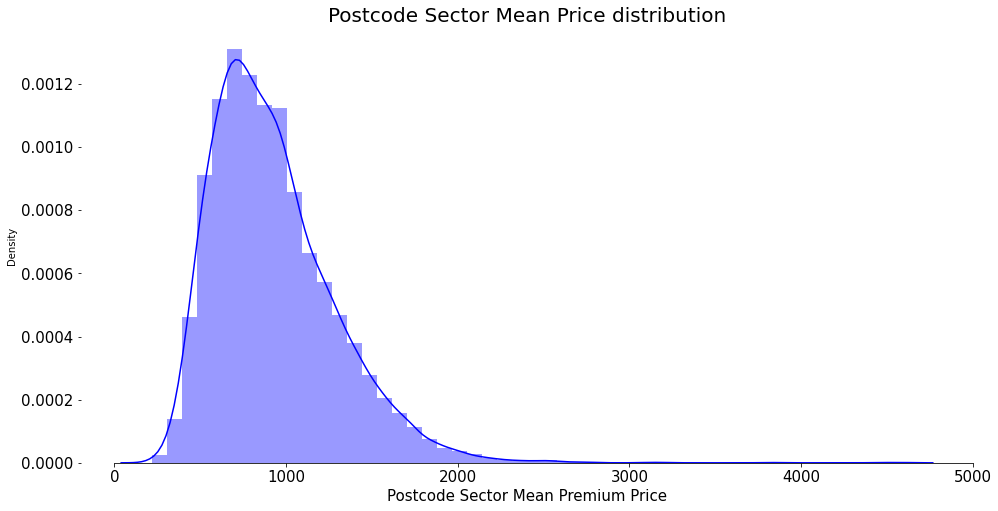

In [20]:
plt.figure(figsize=(16,8))
sns.distplot(dataset['price_mean'], color="b")
plt.xlabel("Postcode Sector Mean Premium Price", fontsize=15)
plt.title("Postcode Sector Mean Price distribution", fontsize=20)
sns.despine(trim=True, left=True)
plt.show()


#### Pearson Correlations of input features with price stats

In [21]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8225 entries, 0 to 8224
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   postcode_sector               8225 non-null   object 
 1   relative_area                 8225 non-null   float64
 2   population_density            8225 non-null   float64
 3   multiple_deprivation_index    8225 non-null   float64
 4   income_deprivation_index      8225 non-null   float64
 5   employment_deprivation_index  8225 non-null   float64
 6   crime_deprivation_index       8225 non-null   float64
 7   rural_urban                   8225 non-null   object 
 8   distance_to_station           8040 non-null   float64
 9   never_worked                  8225 non-null   object 
 10  region                        8225 non-null   object 
 11  road_usage                    7289 non-null   object 
 12  total_offences                6421 non-null   float64
 13  veh

In [22]:
dataset['road_usage'].value_counts()
dataset['road_usage'] = dataset['road_usage'].replace({"..":np.nan})
dataset['road_usage'] = dataset['road_usage'].astype('float64')

In [23]:
dataset.corr()

,relative_area,population_density,multiple_deprivation_index,income_deprivation_index,employment_deprivation_index,crime_deprivation_index,distance_to_station,road_usage,total_offences,vehicle_offences,price_mean,price_std,price_median
relative_area,1.000000,-0.372642,-0.171402,-0.220481,-0.204451,-0.275505,0.415364,0.129693,-0.192086,-0.235303,-0.232915,-0.131929,-0.216249
population_density,-0.372642,1.000000,0.382394,0.402791,0.291206,0.532501,-0.285707,-0.171899,0.308825,0.393070,0.445048,0.218524,0.433599
multiple_deprivation_index,-0.171402,0.382394,1.000000,0.973950,0.957812,0.738795,-0.127290,-0.068004,0.345593,0.291254,0.512937,0.228165,0.519766
income_deprivation_index,-0.220481,0.402791,0.973950,1.000000,0.968051,0.708143,-0.149500,-0.086742,0.315525,0.289020,0.512391,0.238450,0.512243
employment_deprivation_index,-0.204451,0.291206,0.957812,0.968051,1.000000,0.641546,-0.127736,-0.072806,0.274663,0.203120,0.443482,0.201668,0.448112
crime_deprivation_index,-0.275505,0.532501,0.738795,0.708143,0.641546,1.000000,-0.210053,-0.082083,0.340897,0.373752,0.505070,0.243835,0.496867
distance_to_station,0.415364,-0.285707,-0.127290,-0.149500,-0.127736,-0.210053,1.000000,0.152040,-0.158966,-0.231202,-0.166167,-0.073283,-0.158388
road_usage,0.129693,-0.171899,-0.068004,-0.086742,-0.072806,-0.082083,0.152040,1.000000,0.160063,0.077281,-0.104617,-0.043787,-0.104828
total_offences,-0.192086,0.308825,0.345593,0.315525,0.274663,0.340897,-0.158966,0.160063,1.000000,0.893098,0.333071,0.151760,0.324545
vehicle_offences,-0.235303,0.393070,0.291254,0.289020,0.203120,0.373752,-0.231202,0.077281,0.893098,1.000000,0.398699,0.206834,0.374137


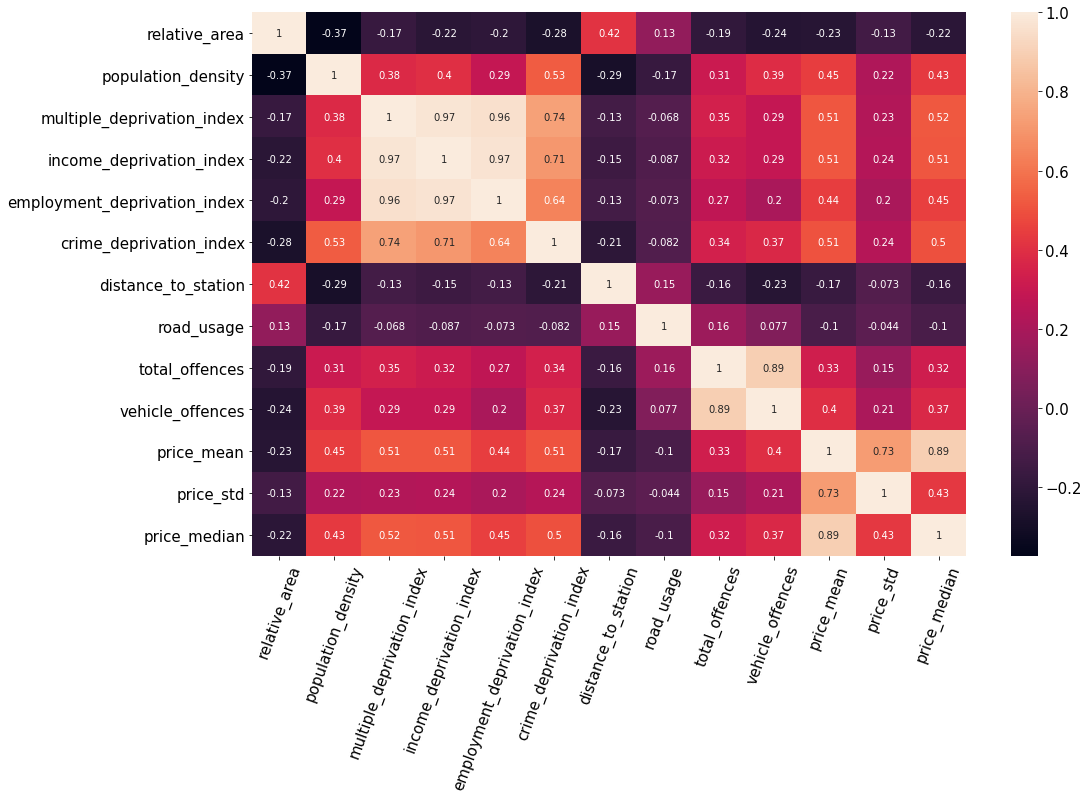

In [24]:
plt.figure(figsize=(16,10))
sns.heatmap(dataset.corr(),annot=True)
plt.xticks(rotation=70) 
plt.show()

Some quick observations:

- It seems that that some indeces are highly co-correlated (income deprivation, multiple deprivation, employement deprivation) -- Since they contain similar information we can remove two of them. Same applies to total offenses and vehicle offenses.

- The mean premium price and the typical (median) premium price per postcode sector seem to have some sort of correlation with the indeces mentioned above plus the crime index. 

In [25]:
# Drop feature with high correlation with others
dataset = dataset.drop(['income_deprivation_index','multiple_deprivation_index', 'vehicle_offences'], axis=1)

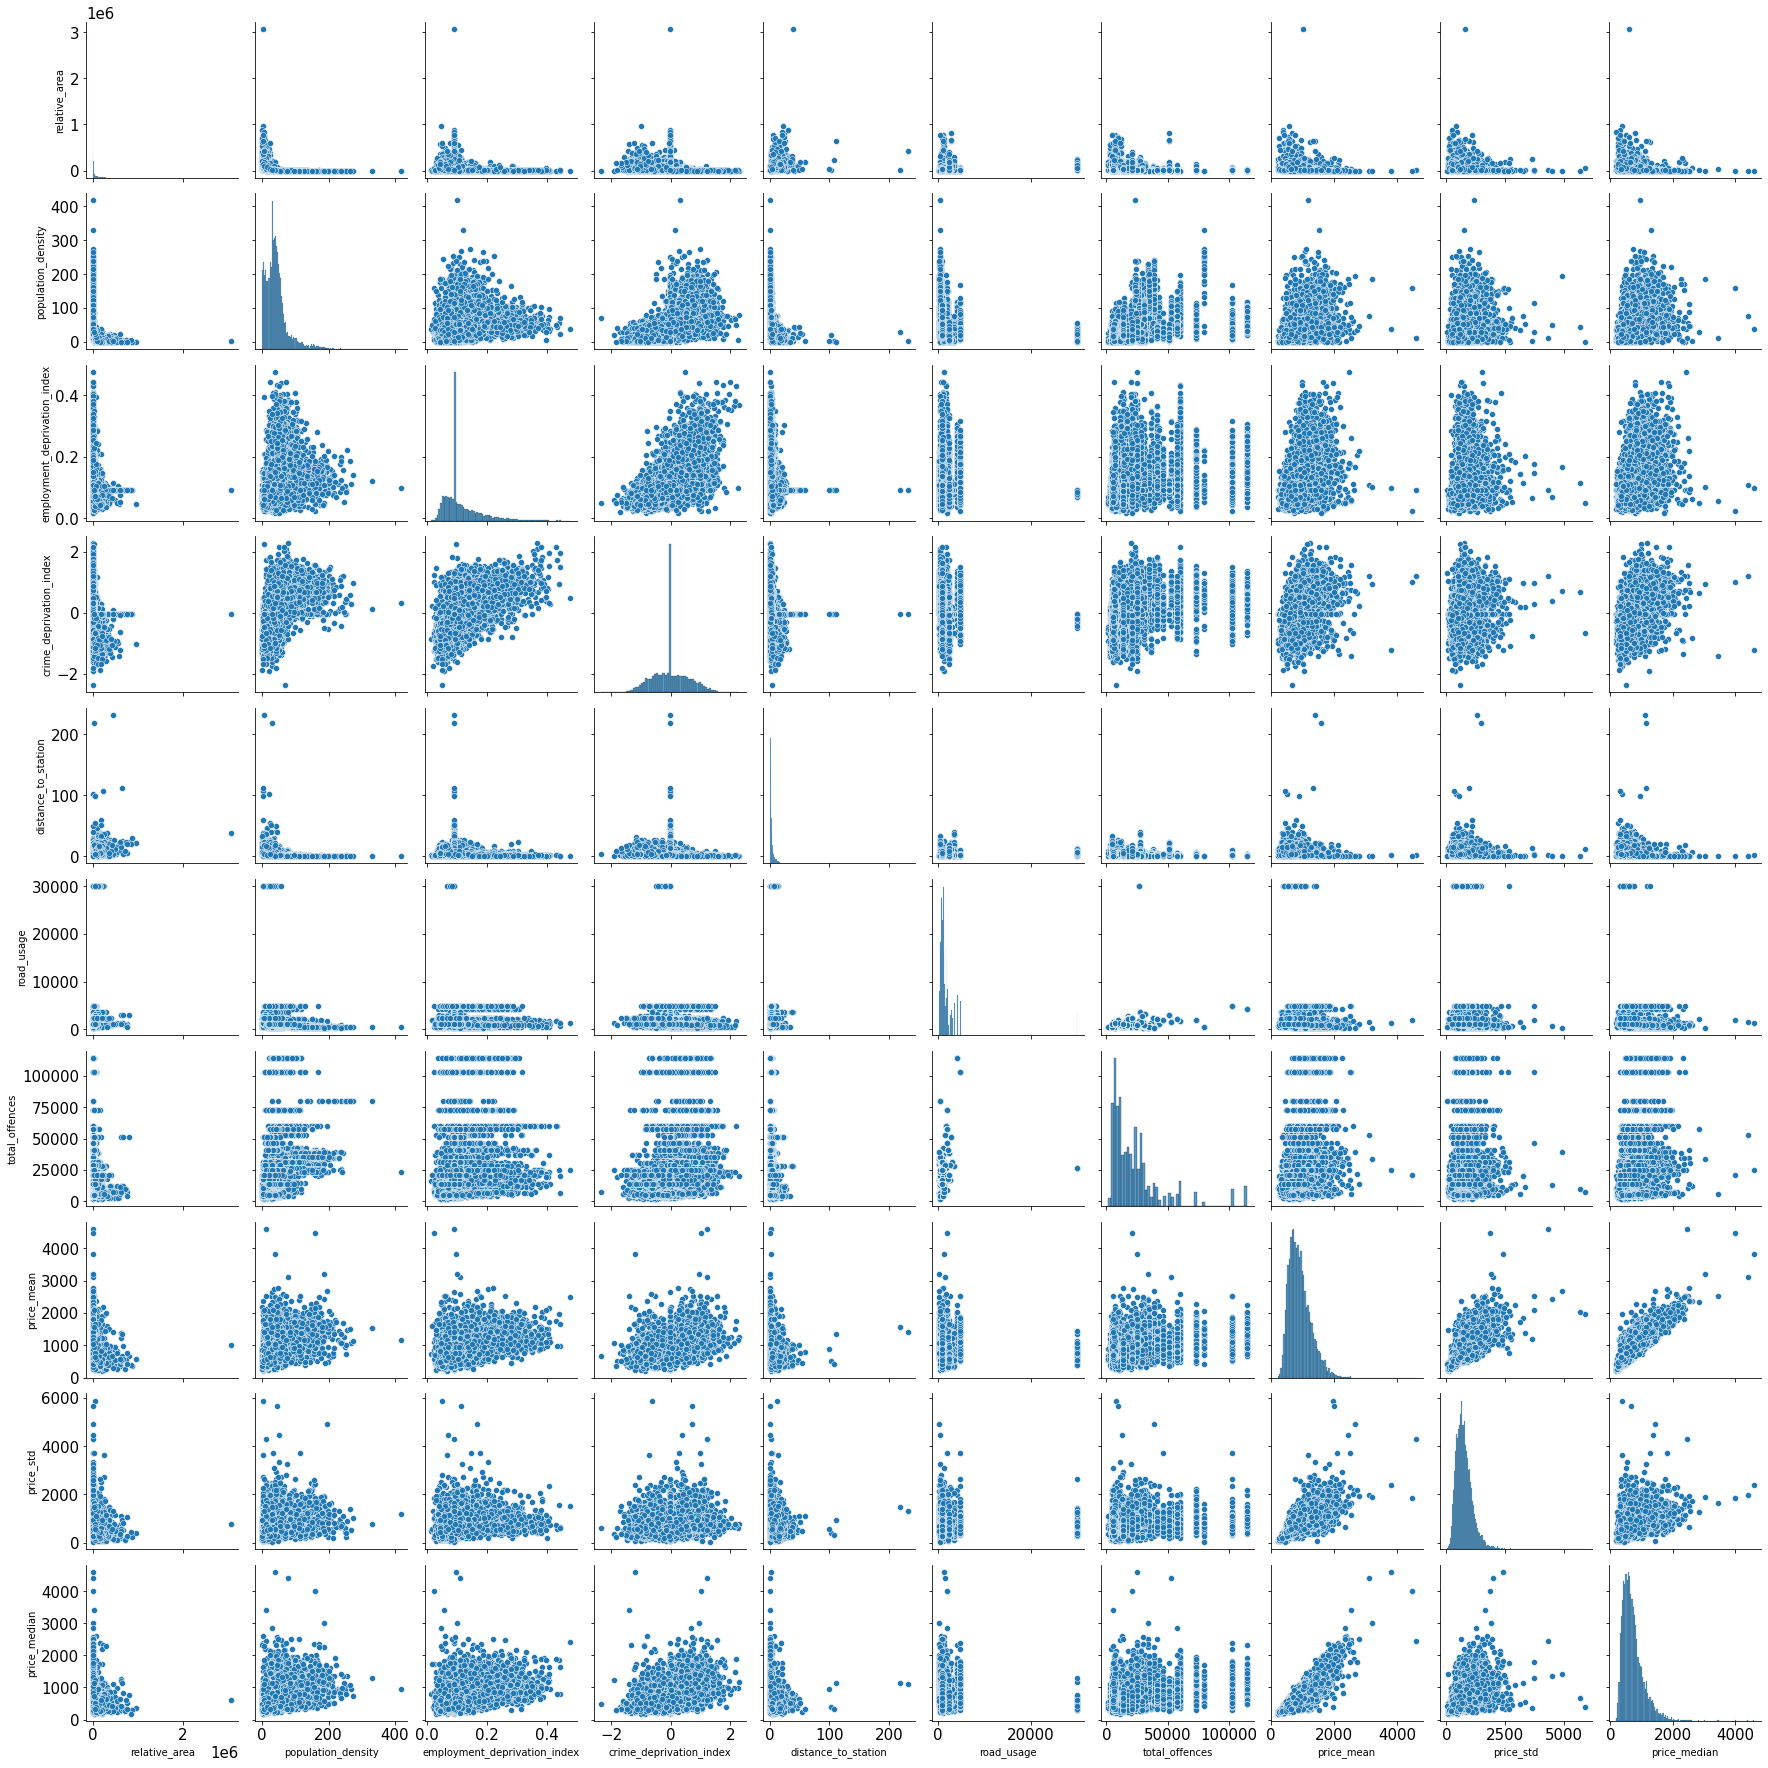

In [26]:
sns.pairplot(dataset)

#### A look on the categorical variables

##### Region 

In [27]:
display(dataset['region'].value_counts())

South East                  1184
North West                  1098
London                       774
South West                   770
East of England              742
Scotland                     739
Yorkshire and The Humber     736
West Midlands                678
East Midlands                534
Wales                        441
North East                   344
Northern Ireland             185
Name: region, dtype: int64

In [28]:
display('Missing regions', dataset['region'].isna().sum())

'Missing regions'

0

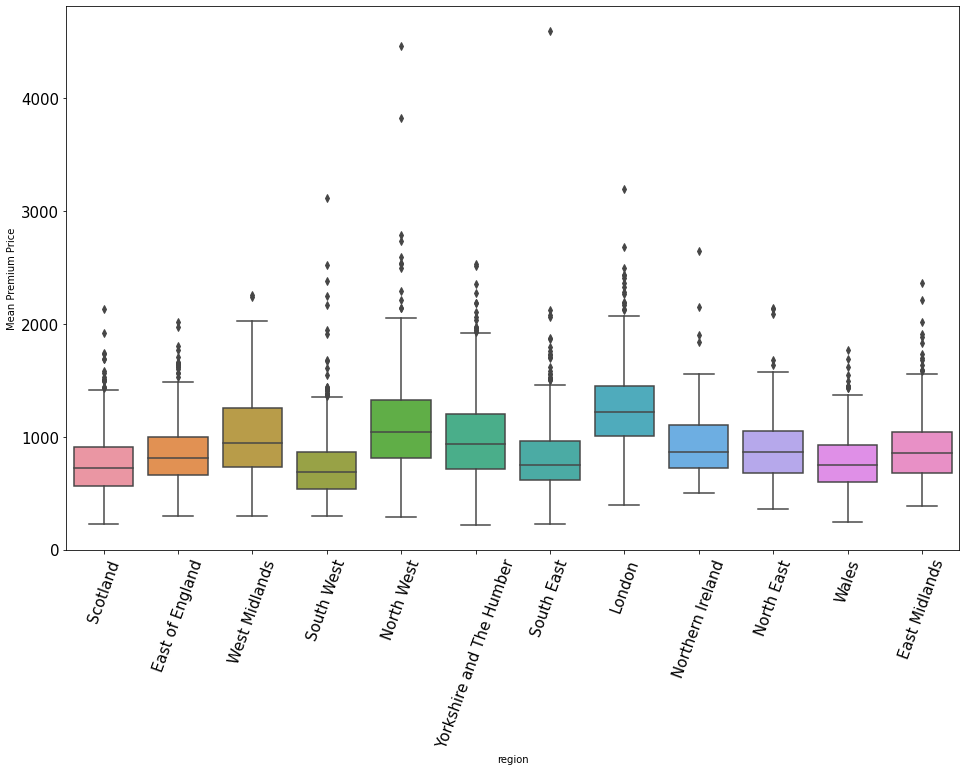

In [29]:
plt.figure(figsize=(16,10))
sns.boxplot(data=dataset, x='region', y='price_mean')
plt.xticks(rotation=70)
plt.ylabel("Mean Premium Price")
plt.show()

Quick note: as probably expected London has a higher mean price.

##### High or Average proportion 

In [30]:
display(dataset['never_worked'].value_counts())
display('Missing entries', dataset['never_worked'].isna().sum())

Average               7408
High                   806
['Average' 'High']      11
Name: never_worked, dtype: int64

'Missing entries'

0

It feels that the "['Average' 'High']" value needs to be updated. Let's have a look the data.

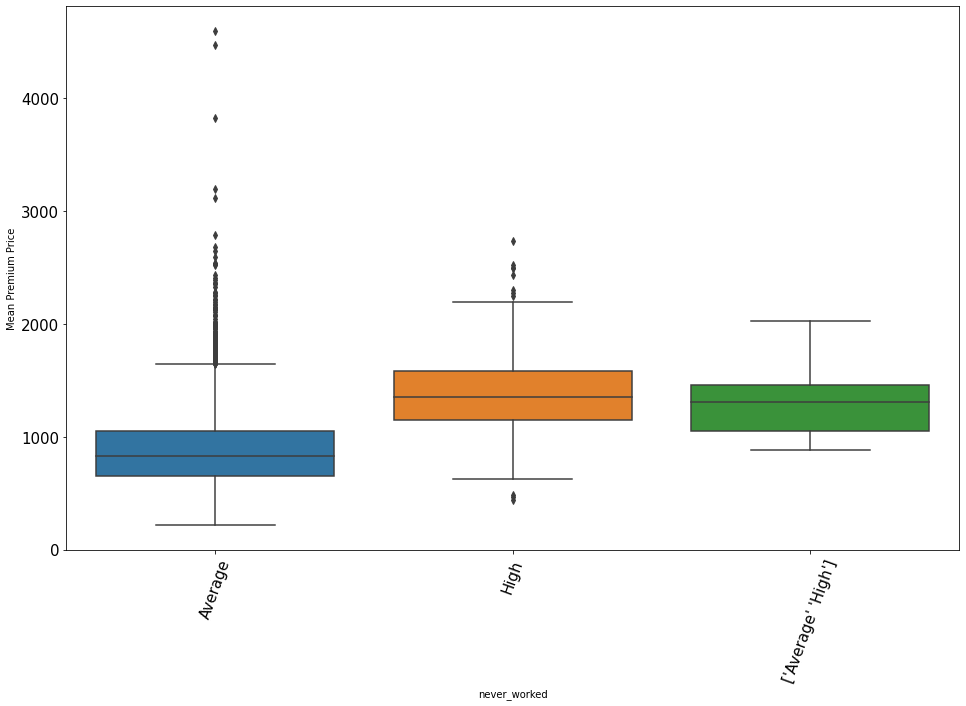

In [31]:
plt.figure(figsize=(16,10))
sns.boxplot(data=dataset, x='never_worked', y='price_mean')
plt.xticks(rotation=70)
plt.ylabel("Mean Premium Price")
plt.show()

Now, it seems that this false entry can be replaced by High.

In [32]:
dataset['never_worked'] = dataset['never_worked'].replace({"['Average' 'High']":'High'})
dataset['never_worked'].value_counts()

Average    7408
High        817
Name: never_worked, dtype: int64

##### Rural Urban

In [33]:
dataset['rural_urban'].value_counts()

Urban city and town                                                  3110
Urban major conurbation                                              2272
Rural town and fringe                                                 748
Rural village                                                         451
Rural hamlet and isolated dwellings                                   274
Large urban area                                                      270
Urban minor conurbation                                               232
Other urban area                                                      212
[]                                                                    185
Accessible rural area                                                  94
Accessible small town                                                  76
Rural hamlet and isolated dwellings in a sparse setting                70
Rural town and fringe in a sparse setting                              62
Rural village in a sparse setting     

We need to fix this input. We 'll come back if there is time.

### Filling Missing Data

In [34]:
display("Proportion of missing entries per feature")
dataset.isna().sum()*100/len(dataset)

'Proportion of missing entries per feature'

postcode_sector                  0.000000
relative_area                    0.000000
population_density               0.000000
employment_deprivation_index     0.000000
crime_deprivation_index          0.000000
rural_urban                      0.000000
distance_to_station              2.249240
never_worked                     0.000000
region                           0.000000
road_usage                      48.012158
total_offences                  21.933131
price_mean                       0.000000
price_std                        0.000000
price_median                     0.000000
dtype: float64

#### Missing data quick fix

In [35]:
dataset['total_offences'] = dataset['total_offences'].fillna(dataset['total_offences'].mean())

dataset['distance_to_station'] = dataset['distance_to_station'].fillna(dataset['distance_to_station'].mean())



Alternatively, we could apply KNN to fill missing data (given the time) which is a more accurate solution.

#### Drop road_usage

In [36]:
### Could investigate more in the future
dataset = dataset.drop('road_usage', axis=1)

### Model to Predict Mean Price

As a first choice, we will apply a Random Forest model since it is a powerful model for non-linear relationship that does not require as much preprocessing compared to other options (e.g. KNN, SVM, neural networks) regarding scaling and outliers and is relatively fast to train and tune compared to boosting models


#### Categorical Feature Encoding


For this reason, we use Label Encoding for the categorical features (one-hot encoding is a good option for gradient-based methods like LR and neural networks but it can hurt tree-based method performance)

In [37]:
le = LabelEncoder()

for feature in ['region', 'never_worked', 'rural_urban']: # encode categorical variables + output to feed into the ML model
    dataset[feature] = le.fit_transform(dataset[feature])


In [38]:
X_train, X_test, y_train, y_test = train_test_split(dataset.drop(['postcode_sector',
                                                                  'price_std',
                                                                  'price_median',
                                                                  'price_mean'], axis=1), 
                                                    dataset['price_mean'], 
                                                    test_size = 0.2, random_state=20)


In [39]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(6580, 9) (6580,) (1645, 9) (1645,)


In [40]:
X_train.head()

,relative_area,population_density,employment_deprivation_index,crime_deprivation_index,rural_urban,distance_to_station,never_worked,region,total_offences
7415,4154.05,50.862295,0.146721,0.565874,12,1.189269,0,7,9999.0
5607,100572.30,8.481081,0.101263,-1.011178,10,3.374044,0,1,9651.0
3300,10997.16,29.453125,0.121951,0.240228,14,1.498827,0,11,24403.0
3050,1054.99,108.698462,0.092154,0.826262,14,0.428276,1,2,29761.0
4948,36936.96,27.392982,0.167214,-0.163396,8,6.623380,0,0,9301.0


#### Model tuning

In [41]:
from sklearn.model_selection import cross_val_score


In [42]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

##### Grid Seaarch

In [43]:
## Search grid for optimal parameters
rf_param_grid = {"max_depth": [5, None],
                "max_features": [2, int(np.sqrt(dataset.shape[1]))],
                "min_samples_split": [2, 3, 10],
                "min_samples_leaf": [1, 3, 10],
                "bootstrap": [True, False],
                "n_estimators" :[ 100,200, 300],
                }

grid_obj = GridSearchCV(RandomForestRegressor(random_state=10), 
                        param_grid = rf_param_grid, 
                        cv=kf, 
                        scoring="neg_mean_absolute_error", 
                        n_jobs= 4, 
                        verbose = 1
                        )

grid_obj.fit(X_train, y_train)

estimator = grid_obj.best_estimator_
results = pd.DataFrame(grid_obj.cv_results_)

display(Markdown("### Results"))
display(Markdown("#### Number of parameter combinations evaluated:"),results.shape[0])
display(Markdown("#### Best Score: "), grid_obj.best_score_)
display(Markdown("#### Best parameters: "), grid_obj.best_params_)
#display("Cross-validation Score: ", np.mean(cvs), np.std(cvs))


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   14.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  6.4min
[Parallel(n_jobs=4)]: Done 1080 out of 1080 | elapsed: 10.8min finished


### Results

#### Number of parameter combinations evaluated:

216

#### Best Score: 

-199.31807551798016

#### Best parameters: 

{'bootstrap': False,
 'max_depth': None,
 'max_features': 2,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'n_estimators': 200}

##### Random Search

In [44]:
## Search grid for optimal parameters
random_params = {"max_depth": np.arange(5,15),
                 "max_features": np.arange(2, dataset.shape[1]),
                 "min_samples_split": np.arange(1,11),
                 "min_samples_leaf": np.arange(1,11),
                 "bootstrap": [True, False],
                 "n_estimators": np.arange(100, 1100, 100),
                }

rsv_obj = RandomizedSearchCV(RandomForestRegressor(random_state=10), 
                                param_distributions = random_params, 
                                cv=kf, 
                                scoring="neg_mean_absolute_error", 
                                n_jobs=-1, 
                                n_iter=20,
                                verbose = 1
                              )

rsv_obj.fit(X_train, y_train)
estimator = rsv_obj.best_estimator_
results = pd.DataFrame(rsv_obj.cv_results_)

display(Markdown("### Results"))
display(Markdown("#### Number of parameter combinations evaluated:"),results.shape[0])
display(Markdown("#### Best Score: "), rsv_obj.best_score_)
display(Markdown("#### Best parameters: "), rsv_obj.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.3min finished


### Results

#### Number of parameter combinations evaluated:

20

#### Best Score: 

-199.17497525255612

#### Best parameters: 

{'n_estimators': 200,
 'min_samples_split': 4,
 'min_samples_leaf': 4,
 'max_features': 2,
 'max_depth': 12,
 'bootstrap': False}

#### Model Building

##### Train the tuned RF model and evaluate performance on Test set

In [45]:
rf_regressor = rsv_obj.best_estimator_
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=12, max_features=2,
                      min_samples_leaf=4, min_samples_split=4, n_estimators=200,
                      random_state=10)

In [46]:
y_train_pred = rf_regressor.predict(X_train)
y_test_pred = rf_regressor.predict(X_test)

##### SVR model

In [47]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
svr_regressor = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
svr_regressor.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(epsilon=0.2))])

In [48]:
print("Mean absolute Error in train Set", np.mean(np.abs(y_train_pred - y_train)))     
print("Mean absolute Error in test Set", np.mean(np.abs(y_test_pred - y_test)))



Mean absolute Error in train Set 149.88967128523268
Mean absolute Error in test Set 201.10248502092426


In [49]:
print("Absolute Error Std in train Set", np.std(np.abs(y_train_pred - y_train)))     
print("Absolute Error Std in test Set", np.std(np.abs(y_test_pred - y_test)))


Absolute Error Std in train Set 139.93880335990835
Absolute Error Std in test Set 196.22385883137702


#### Residual Diagnostics

##### Error Distributions

In [50]:
train_error = y_train_pred - y_train
test_error = y_test_pred - y_test

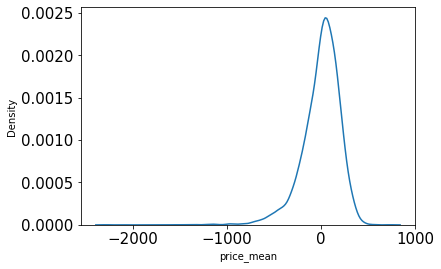

In [51]:
sns.kdeplot(train_error)
plt.show()

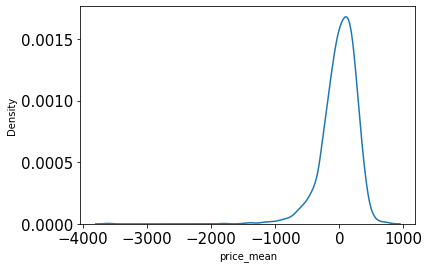

In [52]:
sns.kdeplot(test_error)
plt.show()

In [53]:
print(np.mean(train_error), np.std(train_error))

3.4762601443144595e-14 205.06043558862885


In [54]:
print(np.mean(test_error), np.std(test_error))

0.19804319917772653 280.9732603561387


##### Residual vs Predicted

/anaconda3/envs/sensyne-task/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


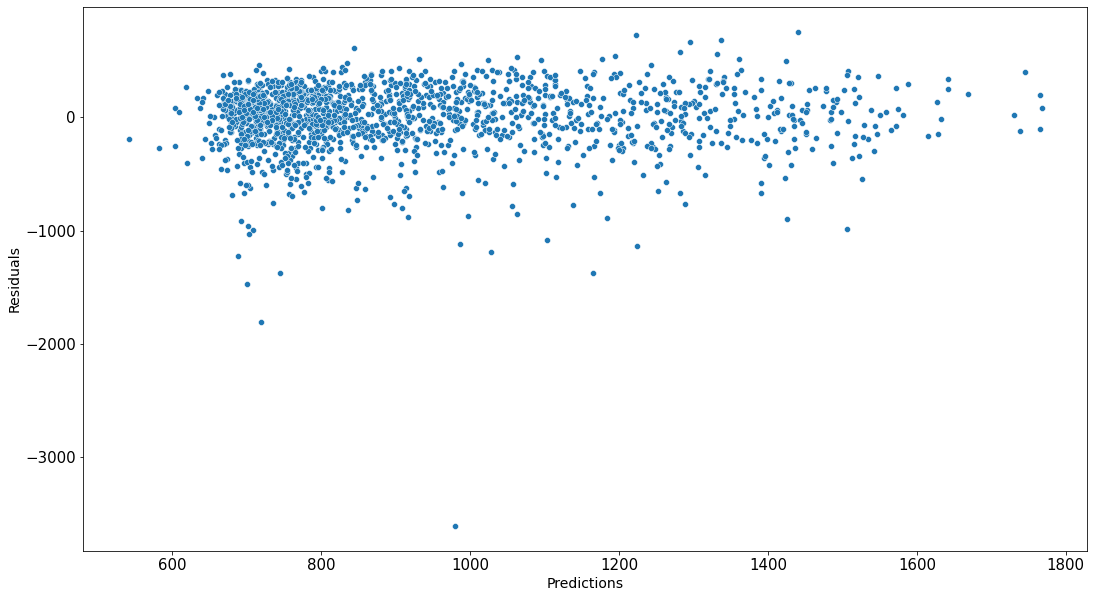

In [68]:
fig = plt.figure(figsize=(18,10))
sns.scatterplot(y_test_pred, test_error)
plt.ylabel('Residuals', fontsize=14)
plt.xlabel('Predictions', fontsize=14)
plt.show()

-- Looks pretty good, maybe we can investigate the outliers.

### Model Explainability -- Feature Importances

Now we want to answer the question which are the most important factors that can affect the mean premium price predictions. We 'll check that by applying a permutation test.

In [56]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rf_regressor, X_train, y_train, n_repeats=30,
                                random_state=42)

In [57]:
feature_importance = pd.DataFrame({"feature": X_train.columns,
                                  "importances_mean": result['importances_mean'], 
                                  "importance_std": result['importances_std']})
feature_importance.sort_values('importances_mean', ascending=False, inplace=True)
feature_importance

,feature,importances_mean,importance_std
3,crime_deprivation_index,0.207640,0.005076
4,rural_urban,0.153380,0.004767
2,employment_deprivation_index,0.138637,0.002457
1,population_density,0.136714,0.002533
0,relative_area,0.113869,0.002657
8,total_offences,0.099935,0.001757
5,distance_to_station,0.085538,0.001484
7,region,0.079001,0.001936
6,never_worked,0.048524,0.001549


In [58]:
feature_importance = pd.DataFrame({"feature": X_train.columns,
                                  "importances_mean": result['importances_mean'], 
                                  "importance_std": result['importances_std']})
feature_importance.sort_values('importances_mean', ascending=False, inplace=True)
feature_importance

,feature,importances_mean,importance_std
3,crime_deprivation_index,0.207640,0.005076
4,rural_urban,0.153380,0.004767
2,employment_deprivation_index,0.138637,0.002457
1,population_density,0.136714,0.002533
0,relative_area,0.113869,0.002657
8,total_offences,0.099935,0.001757
5,distance_to_station,0.085538,0.001484
7,region,0.079001,0.001936
6,never_worked,0.048524,0.001549
